# Lab 2: Exploring Image Data
## by Michael Doherty, Leilani Guzman, and Carson Pittman

## 1. Business Understanding
Self-driving cars. Utter these words and most people will think of a futuristic, technologically advanced society. Yet, believe it or not, the concept of fully autonomous vehicles dates all the way back to the 16th century, when Leonardo da Vinci created a cart that was capable of moving on its own. While it took several centuries before any more progress on autonomous cars was made, since the early 1900s, several advancements have been made in the field. The most notable recent example is Tesla, who has a "Full Self-Driving package" that allows for "hands-free control for highway and freeway driving." Despite this, fully autonomous commercial vehicles have yet to be developed. ([Source](https://www.tomorrowsworldtoday.com/2021/08/09/history-of-autonomous-cars/))

One of the major issues that self-driving cars face is the concept of computer vision. Computer vision is the process by which computers use visual input (such as pictures and videos) to determine what action they should take. For a car to be fully autonomous, it needs to be able to recognize and react to a multitude of scenarios that could occur while driving (in a similiar fashion to how a human driver would react). Thus, self-driving cars need to be able to identify other vehicles and differentiate them from other entities, such as the road and sky.

The dataset we've selected, titled "Vehicle Detection Image Set", was created with this goal in mind. The dataset contains two directories, "vehicles" and "non-vehicles", which can be used to train machine learning models to differentiate between what images contain vehicles and which do not. Each image in the dataset is 64x64 pixels, with pictures in the "vehicles" folder containing images of various cars and pictures in the "non-vehicles" folder containing images of trees, the sky, the road, road signs, and other things a car would "see" while driving.

Thus, the prediction task for this dataset is to determine if any given image contains a vehicle. This is an extremely important concept for a self-driving car to be able to do, so any vehicle company that is working on self-driving cars (both partially and fully autonomous), such as Tesla, would be interested in the results of training machine learning models on this dataset. Hence, the importance of this dataset is clear: it can be used to research new methods for computer vision and improve existing models, all in the hopes of eventually creating a fully self-driving car.

So what does a good prediction algorithm for this dataset look like? There are several factors that need to be considered:
- **Accuracy**: How accurate the prediction algorithm is at classifying vehicles and non-vehicles is one of the most important aspects. As car crashes can be fatal, the prediction algorithm needs to have close to 100% accuracy; at the very least, it needs to be better than humans at identifying what is a vehicle and what is not. 
- **False Positives vs. False Negatives**: The number of false positives (identifying a vehicle when none is present) and false negatives (not identifying a vehicle when one is present) need to be minimized, as both could lead to undesirable situations while driving. However, minimizing the number of false negatives should take priority; while identifying a vehicle when none are present could lead to dangerous situations, failing to identify when a vehicle is present would almost always lead to (potentially fatal) car crashes.
- **Prediction Time**: How long it takes the model to make a prediction for a given image is also extremely important. While driving, an autonomous car is receiving live image data of what is in front of it. If the algorithm takes 5 seconds to make a prediction, it wouldn't be very useful (as it wouldn't be able to make decisions in a safe and reasonable amount of time). Since the average reaction time for humans while driving is 0.75 seconds ([Source](https://www.jdpower.com/cars/shopping-guides/when-driving-what-is-the-average-reaction-time#:~:text=The%20average%20reaction%20time%20when,response%20to%20a%20road%20situation.)), the prediction model should at a minimum be able to match this threshold (and ideally, it should be faster than this).

Ultimately, any machine learning model trained on this data needs to be better than humans to justify its inclusion in an autonomous vehicle. A model that is more accurate, less error prone, and faster at detecting vehicles in an image is a must for any fully autonomous, self-driving car.

Link to the dataset: https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set

## 2. Data Preparation
### 2.1 Read In and Recolor Images, 2.2 Linearize Images

In [7]:
import numpy as np
import PIL
import PIL.Image
import glob
import matplotlib.pyplot as plt

# load in images and labels as numpy arrays
images_and_labels = []

for filename in glob.glob('data/vehicles/*.png'):
    im = PIL.Image.open(filename).convert('L') # convert to grayscale
    im = np.array(im).ravel()
    images_and_labels.append(tuple((im, 'vehicle')))


for filename in glob.glob('data/non-vehicles/*.png'):
    im = PIL.Image.open(filename).convert('L') # convert to grayscale
    im = np.array(im).ravel()
    images_and_labels.append(tuple((im, 'non_vehicle')))
 

print(images_and_labels[0][0].shape[0]) # linearized 64x64 image -> 4096
print('There are', len(images_and_labels), 'images/rows')

4096
There are 17760 images/rows


### 2.3 Visualize Images

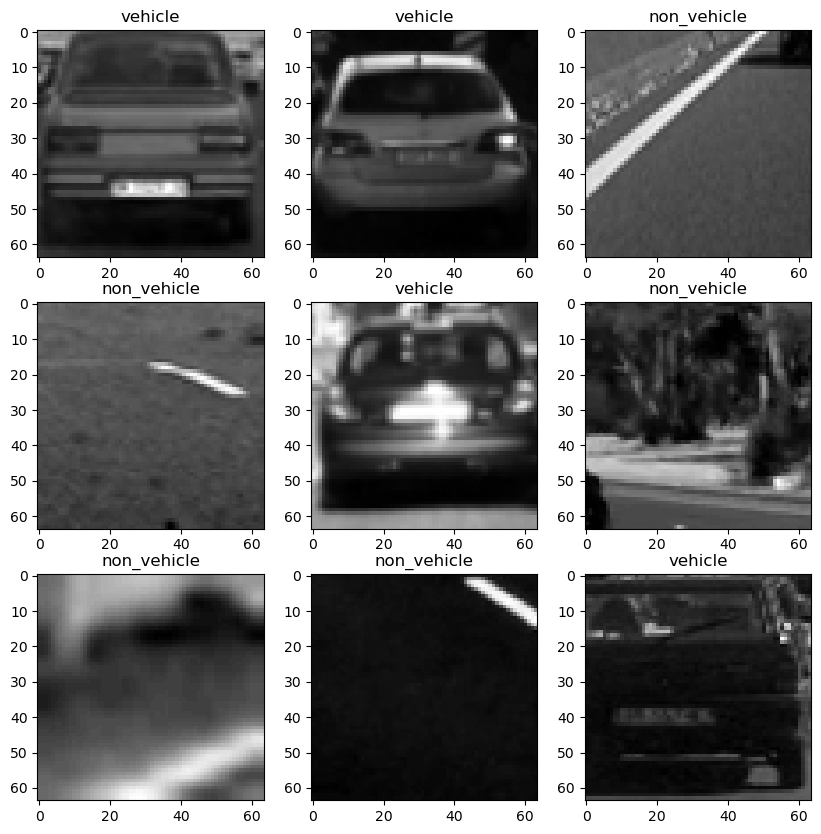

In [3]:
plt.figure(figsize = (10, 10))

# plot some images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    index = np.random.randint(0, len(images_and_labels))
    plt.imshow(images_and_labels[index][0].reshape(64, 64), cmap='gray') # remove cmap if needed
    plt.title(images_and_labels[index][1])

## 3. Data Reduction
### 3.1 Principal Component Analysis

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=images_and_labels[0][0].size)
pca.fit([image for image, label in images_and_labels])
pca.transform([image for image, label in images_and_labels])
print ('pca:\n', pca.components_)

print("Explained Variance for Each Component:", pca.explained_variance_ratio_)

pca:
 [[ 0.01341869  0.01345809  0.01345946 ...  0.01126829  0.01111007
   0.01107859]
 [-0.01862572 -0.0188311  -0.01910649 ...  0.01515648  0.01449854
   0.01402976]
 [ 0.00960369  0.00955185  0.00954491 ...  0.02386171  0.02344508
   0.02307165]
 ...
 [-0.00018479 -0.00078541  0.00193381 ... -0.00719397  0.00272874
   0.00148049]
 [ 0.00285966 -0.00351638  0.00345942 ... -0.00329091  0.00568907
  -0.00056899]
 [ 0.00252492 -0.00380645  0.00263135 ... -0.00379258  0.00088924
   0.00197363]]
Explained Variance for Each Component: [3.49597359e-01 1.23467294e-01 8.59596569e-02 ... 3.29883110e-08
 3.19984675e-08 3.10395652e-08]


Need 228 Principal Components for an Explained Variance of 95%


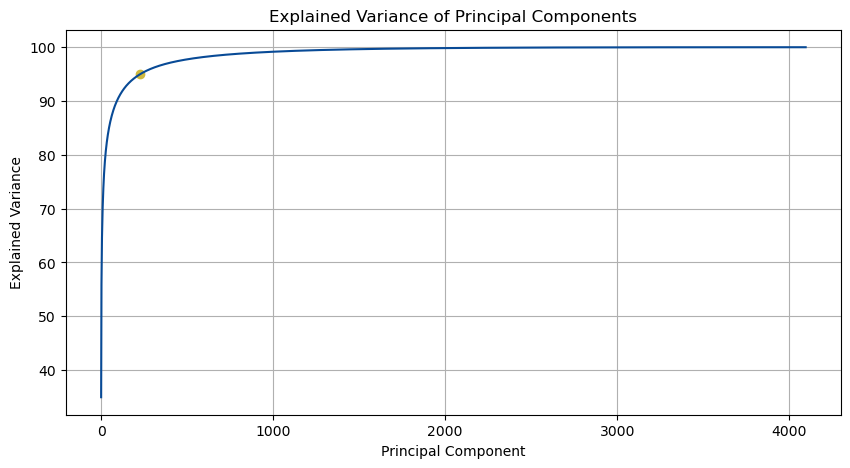

In [62]:
import matplotlib.pyplot as plt

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

target_variance = 0.95
pc_index = np.where(cumulative_explained_variance >= target_variance)[0][0]
print('Need {} Principal Components for an Explained Variance of {}%'.format(pc_index, int(target_variance * 100)))

plt.figure(figsize=(10, 5))
plt.plot(range(len(explained_variance)), 
         cumulative_explained_variance * 100, 
         color='#084a96')
plt.scatter(pc_index, cumulative_explained_variance[pc_index] * 100, c='#cfb93d')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance of Principal Components')
plt.grid()
plt.show()

**ADD ANALYSIS AND CONCLUSION** (We chose 95% as a good threshold as it is around the "knee" of the above graph)

### 3.2 Randomized Principal Component Analysis

### 3.3 PCA vs. Randomized PCA

### 3.4 Feature Extraction using DAISY

In [63]:
from skimage.feature import daisy
from sklearn.metrics.pairwise import pairwise_distances
import copy

def use_daisy(img, dim):
    features = daisy(img.reshape((dim,dim)), step=10, radius=15, rings=2, histograms=8, orientations=4)
    return features.reshape((-1))

#for every image, use daisy to extract features
daisy_features = np.apply_along_axis(use_daisy, 1, np.array([image for image, label in images_and_labels]), 64)
print('Daisy Features Shape:', daisy_features.shape)

distance_matrix = pairwise_distances(daisy_features)


Daisy Features Shape: (17760, 1088)


(-0.5, 63.5, 63.5, -0.5)

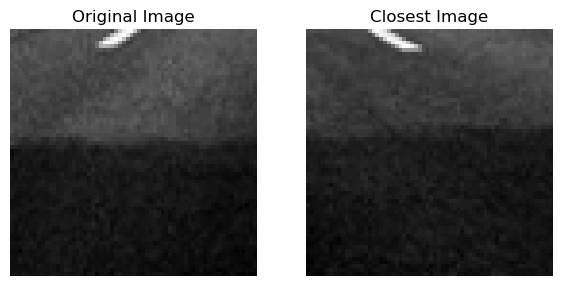

In [65]:
# Find closest image to current image
import sys

index1 = np.random.randint(0, len(images_and_labels))
distances = copy.deepcopy(distance_matrix[index1,:])
distances[index1] = sys.maxsize
index2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
plt.imshow(images_and_labels[index1][0].reshape((64,64)), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(images_and_labels[index2][0].reshape((64,64)), cmap='gray')
plt.title("Closest Image")
plt.axis('off')

ANALYSIS HERE

### 3.5 DAISY Feature Extraction Analysis

In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#assign the features of pca to pca_features
pca_features = pca.transform([image for image, label in images_and_labels])
y = [label for image, label in images_and_labels]

knn_PCA = KNeighborsClassifier(n_neighbors=1)
knn_DAISY = KNeighborsClassifier(n_neighbors=1)

PCA_train, PCA_test, DAISY_train, DAISY_test, y_train, y_test = train_test_split(pca_features, daisy_features, y, test_size=0.2)

# Fit and predict using PCA features
knn_PCA.fit(PCA_train, y_train)
PCA_accuracy = accuracy_score(knn_PCA.predict(PCA_test), y_test)

# Fit and predict using DAISY features
knn_DAISY.fit(DAISY_train, y_train)
DAISY_accuracy = accuracy_score(knn_DAISY.predict(DAISY_test), y_test)

print('PCA Accuracy: {:.2f}%'.format(PCA_accuracy * 100))
print('DAISY Accuracy: {:.2f}%'.format(DAISY_accuracy * 100))

PCA Accuracy: 92.71%
DAISY Accuracy: 97.04%


## 4. Feature Extraction Using DAISY Key Point Matching

DAISY Descriptors (P,Q,R):  (4, 4, 68)


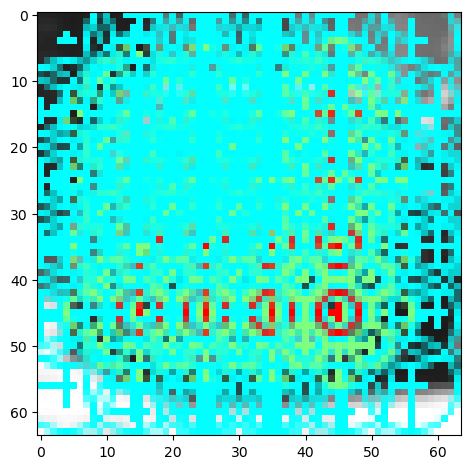

In [10]:
from skimage.io import imshow
from skimage.feature import daisy


# take 2000 images from the first half of the dataset and 2000 from the second half
# to ensure there are vehicles and non-vehicles in the sample
images_and_labels_2 = images_and_labels[:2000] + images_and_labels[10000:12000]

#Example on one image
features, image_description = daisy(images_and_labels_2[0][0].reshape((64,64)), step=10, radius=15, rings=2, histograms=8, 
                                    orientations=4, visualize=True)

imshow(image_description)

print('DAISY Descriptors (P,Q,R): ', features.shape)

In [29]:

def use_daisy(img, dim):
    features = daisy(img.reshape((dim,dim)), step=10, radius=15, rings=2, histograms=8, orientations=4)
    new_shape = features.shape
    return features.reshape((new_shape[0]*new_shape[1], new_shape[2]))

#apply daisy to all images
d_images_and_labels = [tuple((use_daisy(image, 64), label)) for image, label in images_and_labels_2]

print('DAISY features shape', d_images_and_labels[0][0].shape)


DAISY features shape (16, 68)


In [59]:
from skimage.feature import match_descriptors

#finding key points, TESTING PHASE, idk what im doing here

matches_found = []

#find matches between every pair of images, and keep the best match for each pair
for i in range(len(d_images_and_labels)):
    for j in range(i + 1, len(d_images_and_labels)):
        if i != j:
            matches = match_descriptors(d_images_and_labels[i][0], d_images_and_labels[j][0], cross_check=True)
            matches_found.append(tuple((matches.shape[0], i, j)))



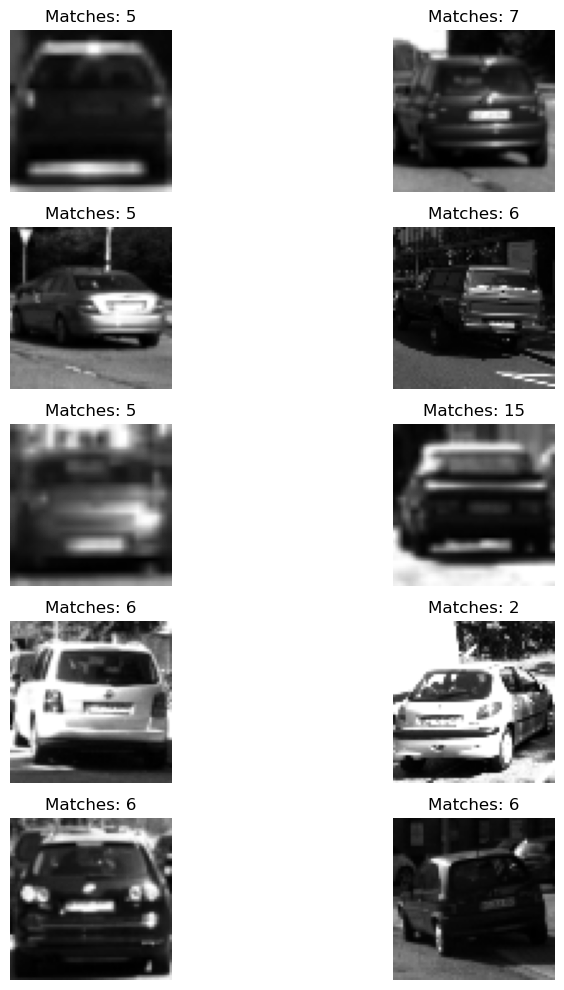

In [60]:

#plot the top 10 matches
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.imshow(images_and_labels_2[matches_found[i][1]][0].reshape((64,64)), cmap='gray')
    plt.axis('off')
    plt.title('Matches: ' + str(matches_found[i][0]))
    plt.subplot(5, 2, i + 1)
    plt.imshow(images_and_labels_2[matches_found[i][2]][0].reshape((64,64)), cmap='gray')
    plt.title('Matches: ' + str(matches_found[i][0]))
    plt.axis('off')

plt.tight_layout()